# Applying StyleNet and the neural style project

# Import

In [173]:
import imageio
from IPython.display import SVG
import numpy as np
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display
import cv2
import PIL.Image
from keras.utils.vis_utils import model_to_dot

Une fois que nous avons formé un CNN de reconnaissance d'image, nous pouvons utiliser le réseau lui-même pour certains traitements de données et d'images intéressants. StyleNet est une procédure qui tente d'apprendre un style d'image à partir d'une image et de l'appliquer à une deuxième image tout en gardant la structure (ou le contenu) de la deuxième image intacte. Pour ce faire, nous devons trouver des nœuds CNN intermédiaires qui présentent une forte corrélation avec un style, indépendamment du contenu de l'image.

StyleNet est une procédure qui prend deux images et applique le style d'une image au contenu de la deuxième image. Les auteurs ont trouvé une propriété dans certains CNN contenant des couches intermédiaires. Certains d'entre eux semblent coder le style d'une image, et d'autres son contenu. À cette fin, si nous entraînons les couches de style sur l'image de style et les couches de contenu sur l'image originale, et que nous propageons en arrière les pertes calculées, nous pouvons modifier l'image originale pour qu'elle ressemble davantage à l'image de style.

Nous avons d'abord chargé les deux images, puis les poids du réseau pré-entraîné et avons attribué des couches aux images de contenu et de style. Nous avons calculé trois fonctions de perte : une perte d'image de contenu, une perte de style et une perte de variation totale. Nous avons ensuite entraîné des images de bruit aléatoire à utiliser le style de l'image de style et le contenu de l'image originale.

Pour ce faire, nous utiliserons le réseau recommandé par Gatys dans A Neural Algorithm of Artistic Style, appelé imagenet-vgg-19.

# Sommaire

[I. Loading images](#Partie1) 

[II. Setting up model](#Partie2) 

## I. Loading images <a class="anchor" id="Partie1"></a>

In [174]:
'''
Declare location of images
'''

content_image_file = 'image/dog.jpg' 
style_image_file = 'image/pointillisme.jpg' 
output_image_file = 'image/dog_pointillisme.jpg' 

In [175]:
'''
Load and resize images
'''

# Read the images
content_image = imageio.imread(content_image_file)
style_image = imageio.imread(style_image_file)
content_image = tf.image.convert_image_dtype(content_image, tf.float32) #Convertit les pixels sur 32 bits et normalise leur valeur
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

# Get shape of target and make the style image the same
target_shape = content_image.shape
style_image = resize(style_image, target_shape)

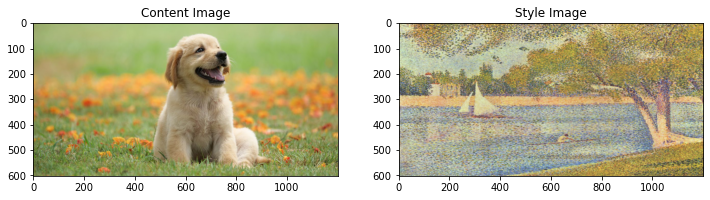

In [176]:
'''
Visualisation of images
'''

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("Style Image")

plt.show()

## II. Setting up model <a class="anchor" id="Partie2"></a>

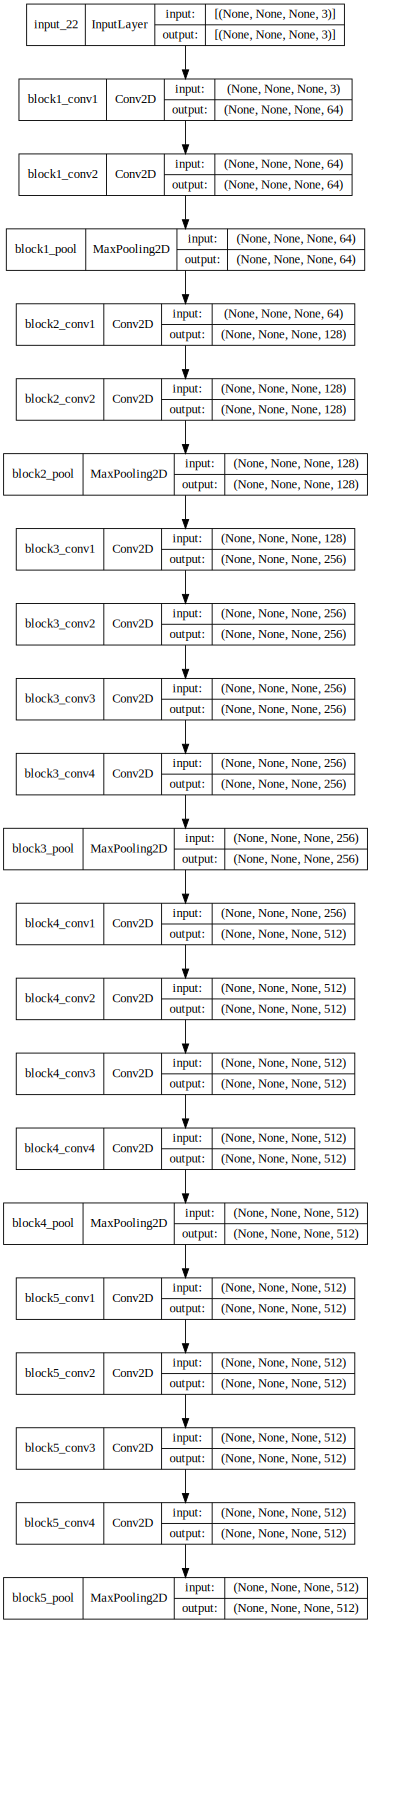

In [177]:
'''
 load the VGG-19 model pre-trained on ImageNet without the classification head
'''

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
SVG(model_to_dot(vgg, show_shapes=True, show_layer_names=True, dpi=65).create(prog="dot",format="svg"))

Un CNN est composé de plusieurs couches de convolution et de pooling. Les couches convolutionnelles extraient les caractéristiques complexes et les couches de pooling fournissent des informations spatiales. On va conserver le bloc4_conv2 pour l'image de contenu, nous pouvons essayer différentes combinaisons des sorties des autres couches du blocX_conv1 pour l'image de style.

In [178]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [179]:
'''
Here, we define the Gram matrix to capture the style of an image. 
The Gram matrix measures the degree of correlation between each of the feature maps

Les 4 dimensions de einsum sont: b=none (correspond juste à une image passée dans le réseau),
i correspond au nombre de ligne, j nombre de colonne et c le nombre de channel. 

Result correspond donc à une matrice carré de dimension: nombre de channel dans input_tensor qui renvoie à
chaque élément de cette matrice la triple somme du produit a[i,j,c]*a[i,j,d].

Cette matrice servira au final de critère pour caractériser le style de l'image. 
'''

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # ligne*colonne 
  return result/(num_locations) # on normalise ensuite les valeurs dans result (une valeur proche de 1 signifie une importante corrélation)

In [180]:
'''
We build a model that returns style and content dictionaries 
that contain the name of each layer and associated content/style tensors. 
The Gram matrix is applied on the style layer
'''

class StyleContentModel(tf.keras.models.Model):
  
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # on vient fixer les outputs de style et contenu que nous avons défini ci-dessus 
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    
    self.vgg = tf.keras.Model([vgg.input], outputs) # On a donc ici 7 outputs (2 contents, 5 style)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
  
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    inputs = inputs[tf.newaxis, :]
    preprocessed_input =  tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs =  (outputs[:self.num_style_layers],outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    # Les dictionnaires construits ci-dessous sont donc de la forme : "block4_conv2": [sortie de la couche block4_conv2]

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [181]:
'''
Set the style and content target values. 
They will be used in the loss computation
'''

# On crée le modèle StyleNet avec les couches affiliées au style et au contenu choisies
extractor = StyleContentModel(style_layers, content_layers) 

# On envoie l'image de style choisie et on récupère le dictionnaire de style qui sera notre target pour le calcul de la loss liée au style
# Cette target à pour but d'apposer progressivement le style à l'image vierge lors de la génération de la nouvelle image modfiée
style_targets = extractor(style_image)['style'] 

# On envoie l'image de contenu choisie et on récupère le dictionnaire de contenu qui sera notre target pour le calcul de la loss liée au contenu
# Cette target à pour but de conserver le contenu de base de l'image vierge lors de la génération de la nouvelle image modfiée
content_targets = extractor(content_image)['content'] 

In [182]:
'''
We will choose the Adam optimizer

We compute the total loss as a weighted sum of the content and the style losses

The content loss will compare our original image and our current image 
(through the content layer features). 
The style loss will compare the style features we have pre-computed with the style features from the input image. 
The third and final loss term will help smooth out the image. We use total variation 
loss here to penalize dramatic changes in neighboring pixels
'''

#Optimizer configuration
learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999
opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2)

content_weight = 5.0
style_weight = 1.0

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # name parcourt les noms des couches, 
    # reduce_mean renvoie la moyenne des éléments à travers toutes les dimensions du tenseur,
    # add_n ajoute éléments par éléments chaque tenseur 
    # On calcule donc d'abord la MSE de chaque couche de style et de content puis on renvoie 
    # un réel qui est la somme des MSE des couches de style et content respectivement
    # On ajuste ensuite ces loss en les pondérant avec les poids définis ainsi que le nombre de couche utilisée pour faire cette loss 
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()]) 
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [183]:
'''
We declare a utility function. As we have a float image, we need to keep the pixel values between 0 and 1.
We declare another utility function to convert a tensor to an image.
'''

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

epoch n° 0
epoch n° 1
epoch n° 2
epoch n° 3
epoch n° 4
epoch n° 5
epoch n° 6
epoch n° 7
epoch n° 8
epoch n° 9
epoch n° 10
epoch n° 11
epoch n° 12
epoch n° 13
epoch n° 14
epoch n° 15
epoch n° 16
epoch n° 17
epoch n° 18
epoch n° 19
epoch n° 20
epoch n° 21
epoch n° 22
epoch n° 23
epoch n° 24
epoch n° 25
epoch n° 26
epoch n° 27
epoch n° 28
epoch n° 29


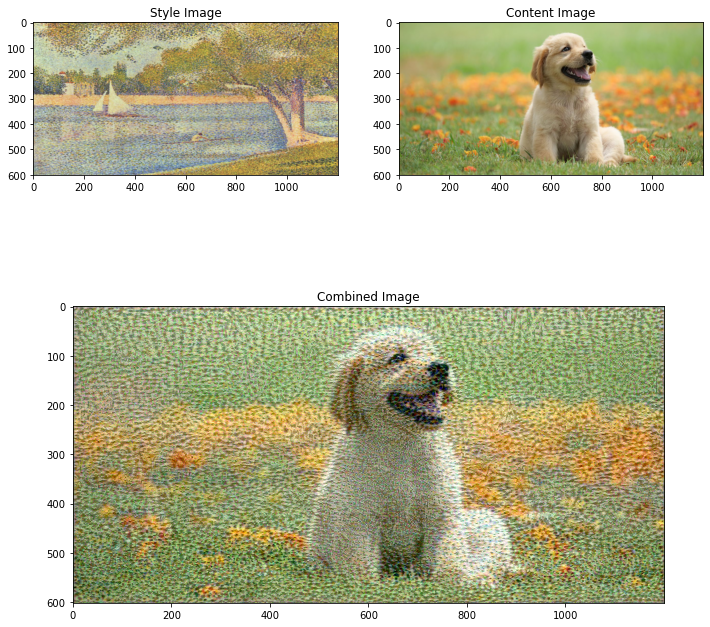

In [184]:
'''
Next, we use gradient tape to run the gradient descent, generate our new image, and display it, as follows

Le processus "d'entraînement" ici est assez différent de ce que l'on voit d'habitude car on ne va pas modifier les poids 
de notre modèle mais on va directement modifier l'image d'entrée à chaque Epoch que l'on réinjecte ensuite ainsi 
modifiée dans le processsus d'entraînement pour l'epoch suivante.

L'optimisation est directement appliquée pixel par pixel sur la variable courante à chaque epoch.
'''

# Une variable TensorFlow est la méthode recommandée pour représenter 
# l'état partagé et persistant manipulé par votre programme. 
# Une variable représente un tenseur dont la valeur peut être modifiée en exécutant ops dessus. 
# Des opérations spécifiques permettent de lire et de modifier les valeurs de ce tenseur. 

# TensorFlow "enregistre" les opérations pertinentes exécutées dans le contexte d'un tf.GradientTape 
# sur une "bande": tape. TensorFlow utilise ensuite cette bande pour calculer 
# les gradients d'un calcul "enregistré" ici: calcul des outputs et de la loss

epochs = 30
image = tf.Variable(content_image)
for generation in range(epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(image) # On crée notre dictionnaire contenant les dico de style et de content pour notre variable
        loss = style_content_loss(outputs) # On calcule la loss
    grad = tape.gradient(loss, image) # On utilise la bande en question pour calculer le gradient de la loss sur l'image
    opt.apply_gradients([(grad, image)]) # On applique les gradients calculés avec l'optimisation choisi sur la variable image
    image.assign(clip_0_1(image)) # On garde les valeurs des pixels entre 0 et 1
    print("epoch n°",generation)


plt.figure()

plt.subplot(2, 2, 2)
plt.imshow(content_image)
plt.title("Content Image")

plt.subplot(2, 2, 1)
plt.imshow(style_image)
plt.title("Style Image")

plt.subplot(2, 1, 2)
plt.imshow(tensor_to_image(image))
plt.title("Combined Image")

plt.show()

In [185]:
imageio.imsave(output_image_file, tensor_to_image(image))